# Wavelets, compression and compressed sensing in magnetic resonance imaging

## Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, CenteredNorm, LinearSegmentedColormap
import matplotlib as mpl
import nibabel as nib
import pywt
import ipywidgets as widgets
from ipywidgets import HBox, VBox, Output, interactive_output
from tqdm import tqdm

## Process raw data

Sagittal (256, 256)
Coronal (256, 176)
Axial (256, 176)
Sagittal (256, 256)
Coronal (256, 176)
Axial (256, 176)


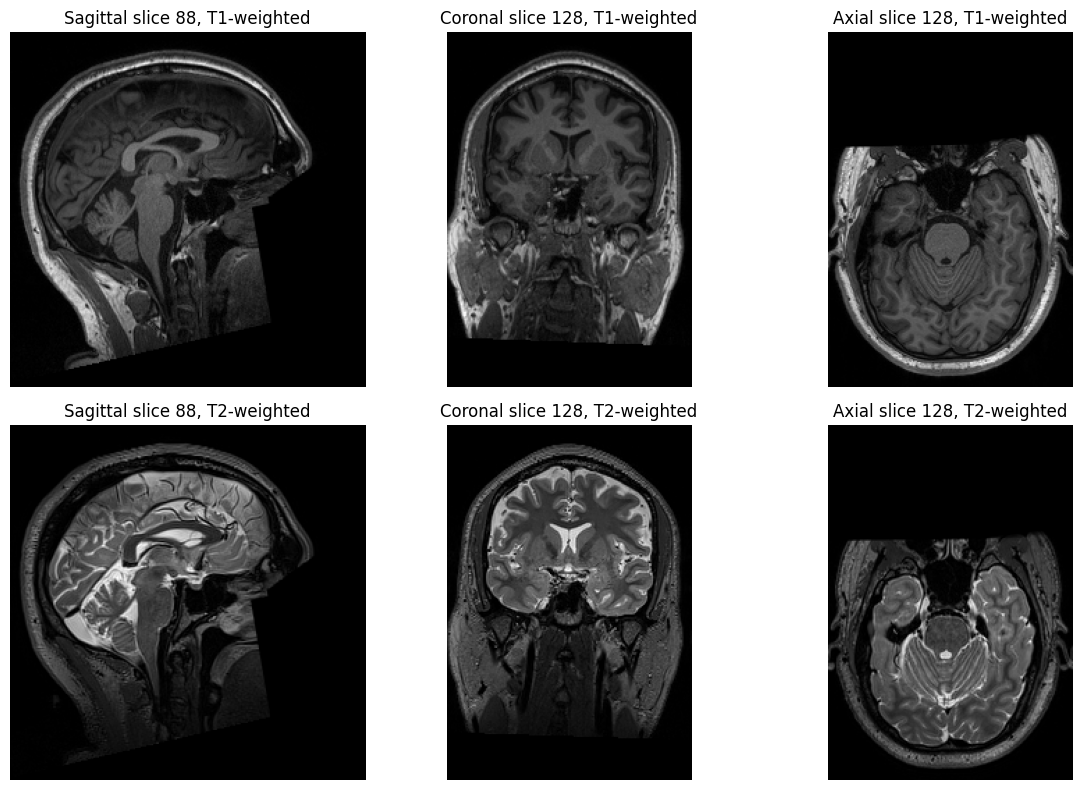

In [3]:
t1_file = nib.load('ds001499/sub-CSI1/ses-16/anat/sub-CSI1_ses-16_run-01_T1w.nii.gz')
t2_file = nib.load('ds001499/sub-CSI1/ses-16/anat/sub-CSI1_ses-16_T2w.nii.gz')

t1 = t1_file.get_fdata()
t2 = t2_file.get_fdata()

# Middle indices
sag_idx = t1.shape[0] // 2
cor_idx = t1.shape[1] // 2
axi_idx = t1.shape[2] // 2

# Helper to extract and scale a slice
def get_slice(vol, axis, idx):
    if axis in ['Sagittal', 0]:
        slice = vol[idx, :, :]
    elif axis in ['Coronal', 1]:
        slice = vol[:, idx, :]
    elif axis in ['Axial', 2]:
        slice = vol[:, :, idx]
    return np.rot90((slice - np.min(slice)) / (np.max(slice) - np.min(slice)))
 
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Top row: T1
for ax, (axis, idx) in zip(axes[0], 
                           [('Sagittal', sag_idx),
                            ('Coronal', cor_idx),
                            ('Axial',   axi_idx)]):
    img = get_slice(t1, axis, idx)
    print(axis, img.shape)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'{axis} slice {idx}, T1‑weighted')

# Bottom row: T2
for ax, (axis, idx) in zip(axes[1],
                           [('Sagittal', sag_idx),
                            ('Coronal', cor_idx),
                            ('Axial',   axi_idx)]):
    img = get_slice(t2, axis, idx)
    print(axis, img.shape)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
    ax.set_title(f'{axis} slice {idx}, T2‑weighted')

fig.tight_layout()
fig.savefig("figures/cross-sections.svg", transparent=True, bbox_inches='tight')

## Absolute Value Color Map

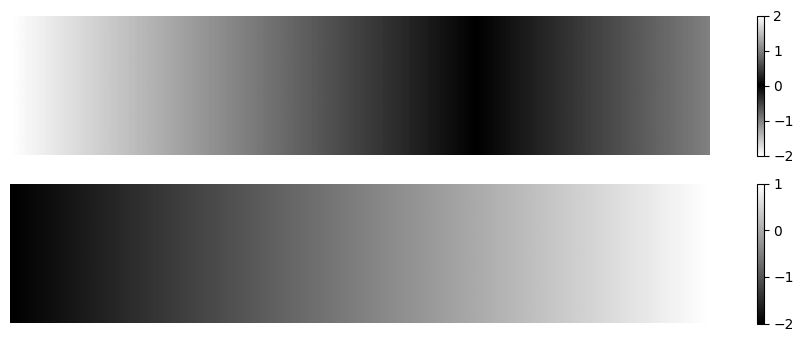

In [4]:
colors = [(1, 1, 1), (0, 0, 0), (1, 1, 1)]

abs_gray = LinearSegmentedColormap.from_list("abs_gray", colors)
if "abs_gray" not in mpl.colormaps:
    mpl.colormaps.register(cmap=abs_gray)

data = np.linspace(-2, 1, 500)
data = np.vstack([data] * 100)

fig, axes = plt.subplots(2, 1, figsize=(12, 4))
axes[0].imshow(data, cmap='abs_gray', norm=CenteredNorm())
axes[0].axis('off')
axes[1].imshow(data, cmap='gray', norm=Normalize())
axes[1].axis('off')
fig.colorbar(axes[0].imshow(data, cmap='abs_gray', norm=CenteredNorm()), ax=axes[0])
fig.colorbar(axes[1].imshow(data, cmap='gray', norm=Normalize()), ax=axes[1])
fig.show()

(256, 256)

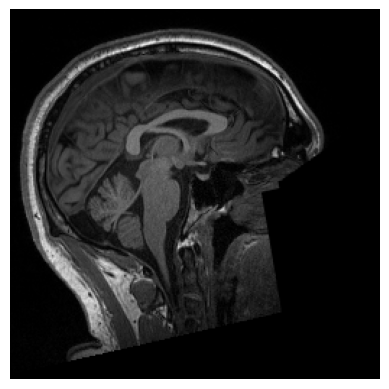

In [5]:
guide = get_slice(t1, 'Sagittal', sag_idx)
plt.imshow(guide, cmap='gray')
plt.axis('off')
guide.shape

(256, 256)

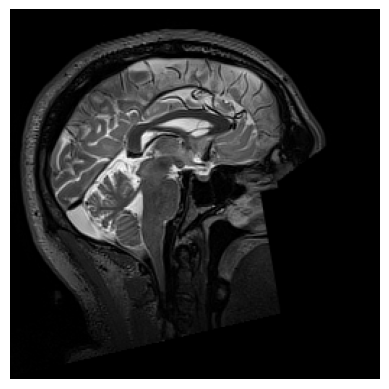

In [6]:
guide_T2 = get_slice(t2, 'Sagittal', sag_idx)
plt.imshow(guide_T2, cmap='gray')
plt.axis('off')
guide_T2.shape

## Helper Functions

### Normalize to [0, 1]

In [7]:
def normalize_01(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img)) if np.max(img) - np.min(img) > 0 else np.zeros_like(img)

arr = np.array([-2, -1, 0, 1, 2, 3])
normalized = normalize_01(arr)
print("arr:         ", arr)
print("normalized:  ", normalized)


arr:          [-2 -1  0  1  2  3]
normalized:   [0.  0.2 0.4 0.6 0.8 1. ]


### Normalize Centered

normalize to [-1, 1] where 1 is the absolute min or max

In [8]:
def normalize_centered(img):
    return img / np.max(np.abs(img)) if np.max(np.abs(img)) > 0 else np.zeros_like(img)

arr = np.array([-2, -1, 0, 1, 2, 3])
normalized = normalize_centered(arr)
print("arr:         ", arr)
print("normalized:  ", normalized)

arr:          [-2 -1  0  1  2  3]
normalized:   [-0.66666667 -0.33333333  0.          0.33333333  0.66666667  1.        ]


### Compress Array

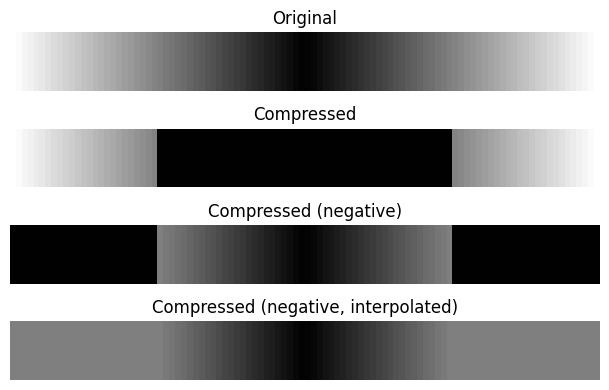

In [9]:
def compress_array(arr, s, interpolate=False):
    abs_arr = np.abs(arr)
    
    if s < 0:
        thresh = np.percentile(abs_arr, 100 + s)
        mask = abs_arr <= thresh
        compressed_arr = arr * mask
        
        if interpolate:
            arr_max = np.max(compressed_arr)
            arr_min = np.min(compressed_arr)
            
            compressed_arr[(compressed_arr == 0) & (arr < 0)] = arr_min
            compressed_arr[(compressed_arr == 0) & (arr > 0)] = arr_max
    else:
        thresh = np.percentile(abs_arr, s)
        mask = abs_arr >= thresh
        compressed_arr = arr * mask

    return compressed_arr

x = np.tile(np.linspace(-1, 1, 100), (10, 1))
y = compress_array(x, 50)

cmap = 'abs_gray'
norm_factory = CenteredNorm()
    
fig, axes = plt.subplots(4, 1, figsize=(10, 4))
axes[0].imshow(x, cmap=cmap, norm=norm_factory)
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(y, cmap=cmap, norm=norm_factory)
axes[1].set_title('Compressed')
axes[1].axis('off')
axes[2].imshow(compress_array(x, -50), cmap=cmap, norm=norm_factory)
axes[2].set_title('Compressed (negative)')
axes[2].axis('off')
axes[3].imshow(compress_array(x, -50, interpolate=True), cmap=cmap, norm=norm_factory)
axes[3].set_title('Compressed (negative, interpolated)')
axes[3].axis('off')

plt.tight_layout()

### Get MSE

In [10]:
def get_mse(pred, truth):
    return np.mean((pred - truth)**2)
get_mse(y, x)

np.float64(0.04249566370778493)

### Describe Array

In [11]:
def describe_array(arr, print_stats=True, stats=['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']):
    all_stats = {
        'count': arr.size,
        'mean': arr.mean(),
        'std': arr.std(),
        'min': arr.min(),
        '25%': np.percentile(arr, 25),
        '50%': np.percentile(arr, 50),
        '75%': np.percentile(arr, 75),
        'max': arr.max()
    }
    selected_stats = {key: all_stats[key] for key in stats}
    if print_stats:
        for key, value in selected_stats.items():
            print(f"{key}: {value:.2f}")
    return selected_stats
    
description = describe_array(guide)

count: 65536.00
mean: 0.12
std: 0.16
min: 0.00
25%: 0.00
50%: 0.04
75%: 0.19
max: 1.00


### Get ax

In [12]:
def get_ax(axes, r, c):
    return axes[c] if axes.ndim == 1 else axes[r, c]

### Plot Row

In [13]:
def plot_row(axes, row, 
             img, img_title,
             transform_img, transform_title,
             hist_array, hist_bins, hist_title, hist_zero_bin=True,
             cmap='gray', norm_factory=Normalize,):
    # Column 0: image
    ax0 = get_ax(axes, row, 0)
    ax0.imshow(img, cmap=cmap, norm=norm_factory())
    ax0.set_title(img_title)
    ax0.axis('off')

    # Column 1: transform
    ax1 = get_ax(axes, row, 1)
    ax1.imshow(transform_img, cmap=cmap, norm=norm_factory())
    ax1.set_title(transform_title)
    ax1.axis('off')

    # Column 2: histogram
    hist, bin_edges = np.histogram(hist_array.ravel(), bins=hist_bins)
    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Set the count of the bin containing zero to zero
    if not hist_zero_bin:
        # Find the index of the bin that includes zero
        zero_bin_index = np.searchsorted(bin_edges, 0, side='right') - 1
        if 0 >= bin_edges[0] and 0 <= bin_edges[-1]:
            hist[zero_bin_index] = 0
    # Plot
    ax2 = get_ax(axes, row, 2)
    ax2.bar(bin_centers, hist, width=np.diff(bin_edges), align='center')
    ax2.set_title(hist_title)


## Test Gratings

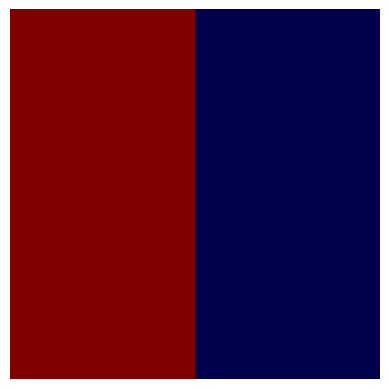

array([[ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       ...,
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]], shape=(256, 256))

In [14]:
def generate_grating(frequencies, type='sine', size=512, direction='horizontal', phase_shift=0):
    x = np.linspace(0, 2 * np.pi, size)
    y = np.linspace(0, 2 * np.pi, size)
    X, Y = np.meshgrid(x, y)
    grating = np.zeros((size, size))

    if direction == 'horizontal':
        grating_direction = X
    elif direction == 'vertical':
        grating_direction = Y
    elif direction == 'diagonal':
        grating_direction = X + Y
    elif direction == 'anti-diagonal':
        grating_direction = X - Y
    
    # Add sinusoidal components for each frequency
    for freq in frequencies:
        sin_value = np.sin(freq * grating_direction + phase_shift)
        if type == 'sine':
            grating += sin_value
        elif type == 'square':
            grating += np.where(np.sign(sin_value) == 0, 1, np.sign(sin_value)) # avoid zero values (imperfect solution because phase shift and max frequency edge cases)

    return grating

grating = generate_grating(frequencies=[1], type='square', size=256, direction='horizontal', phase_shift=0)

plt.imshow(grating, cmap='seismic', norm=CenteredNorm())
plt.axis('off')
plt.show()
grating[0,127], grating[0,128]
grating

## Plot Wavelet Function

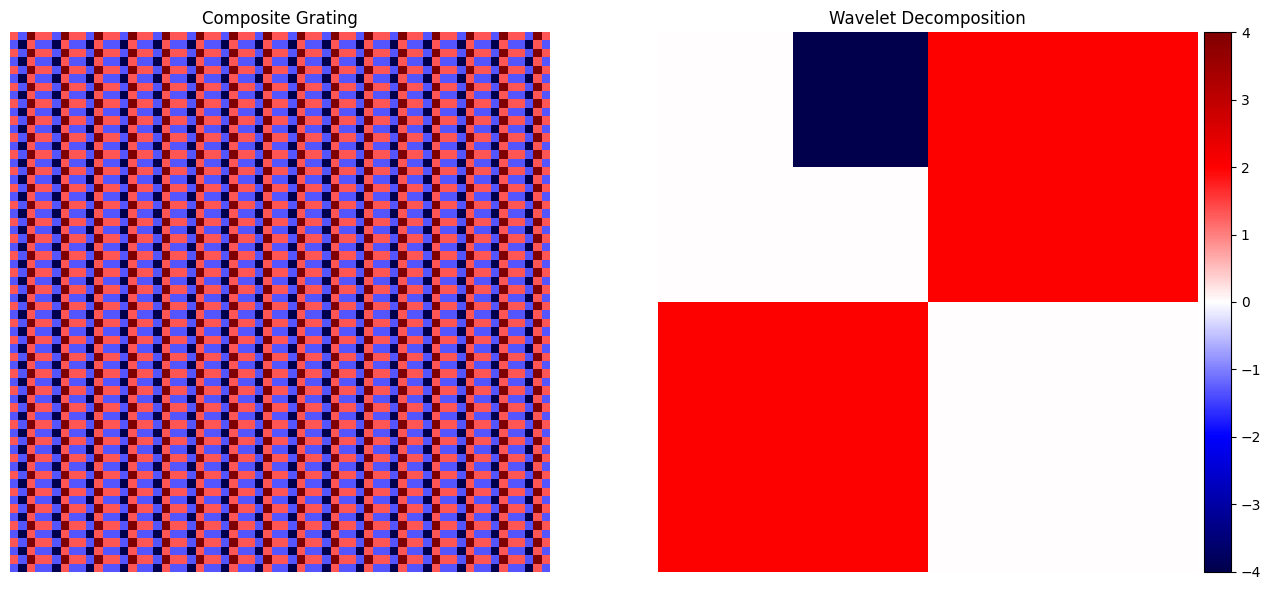

In [15]:
def plot_wavelet(img, wavelet='haar', level=None, 
                 cmap='abs_gray', norm_factory=CenteredNorm, ax=None, 
                 normalize_indep=False, normalize_function=normalize_centered, 
                 verbose=False, return_arr=False):
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)

    if normalize_indep:
        norm_coeffs = [normalize_function(coeffs[0])]
        for i, (cH, cV, cD) in enumerate(coeffs[1:], 1):
            norm_cH = normalize_function(cH)
            norm_cV = normalize_function(cV)
            norm_cD = normalize_function(cD)
            norm_coeffs.append((norm_cH, norm_cV, norm_cD))
        coeffs = norm_coeffs
        arr, slices = pywt.coeffs_to_array(norm_coeffs)
    else:
        arr, slices = pywt.coeffs_to_array(coeffs)
        
    if verbose:
        print("Approximation coefficients (Level 0):")
        print(f"  min: {coeffs[0].min()}, max: {coeffs[0].max()}")
        for i, (cH, cV, cD) in enumerate(coeffs[1:], 1):
            print(f"Detail coefficients (Level {i}):")
            print(f"  Horizontal (cH): min = {cH.min()}, max = {cH.max()}")
            print(f"  Vertical   (cV): min = {cV.min()}, max = {cV.max()}")
            print(f"  Diagonal   (cD): min = {cD.min()}, max = {cD.max()}")

    if ax:
        ax.imshow(arr, cmap=cmap, norm=norm_factory())
        ax.axis('off')

    if return_arr:
        return arr, slices
    else:
        return coeffs

size = 64
grating_1 = generate_grating(frequencies=[32], type='square', size=size, direction='horizontal', phase_shift=0)
grating_2 = generate_grating(frequencies=[32], type='square', size=size, direction='vertical', phase_shift=0)
grating_3 = -generate_grating(frequencies=[16], type='square', size=size, direction='horizontal', phase_shift=0) # negative acts as a phase shift(actual phase shift causes edge case artifact)
composite_grating = grating_1 + grating_2 + grating_3

# composite_grating = generate_grating(frequencies=[32], type='square', size=size, direction='diagonal', phase_shift=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].imshow(composite_grating, cmap='seismic', norm=CenteredNorm())
axes[0].axis('off')
axes[0].set_title('Composite Grating')
coeffs = plot_wavelet(composite_grating, wavelet='haar', level=2, cmap='seismic', ax=axes[1], normalize_indep=False)
axes[1].set_title('Wavelet Decomposition')
fig.colorbar(axes[1].images[0], ax=axes[1], orientation='vertical', pad=0.01)
fig.tight_layout()

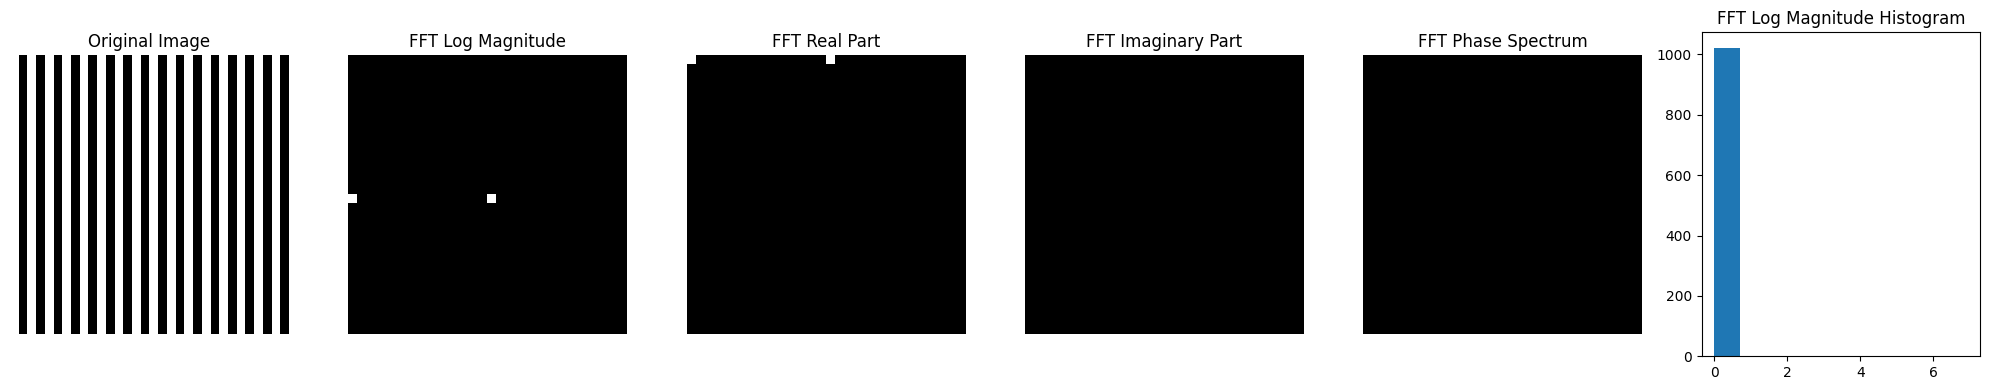

In [16]:
def plot_fft2(img, cmap='gray', norm_factory=Normalize, hist_bins=300, axes=None, axes_row=0):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    f_mag = np.abs(fshift)
    f_log_mag = np.log1p(f_mag)
    real_part = np.real(f)
    imag_part = np.imag(f)
    phase_spectrum = np.angle(f)

    if axes is not None:
        # original image
        get_ax(axes, axes_row, 0).imshow(img, cmap=cmap, norm=norm_factory())
        get_ax(axes, axes_row, 0).set_title('Original Image')
        get_ax(axes, axes_row, 0).axis('off')

        # FFT log-magnitude image
        get_ax(axes, axes_row, 1).imshow(f_log_mag, cmap=cmap, norm=norm_factory())
        get_ax(axes, axes_row, 1).set_title('FFT Log Magnitude')
        get_ax(axes, axes_row, 1).axis('off')
        
        # FFT real part
        get_ax(axes, axes_row, 2).imshow(real_part, cmap=cmap, norm=norm_factory())
        get_ax(axes, axes_row, 2).set_title('FFT Real Part')
        get_ax(axes, axes_row, 2).axis('off')
        
        # FFT imaginary part
        get_ax(axes, axes_row, 3).imshow(imag_part, cmap=cmap, norm=norm_factory())
        get_ax(axes, axes_row, 3).set_title('FFT Imaginary Part')
        get_ax(axes, axes_row, 3).axis('off')
        
        # FFT phase spectrum
        get_ax(axes, axes_row, 4).imshow(phase_spectrum, cmap=cmap, norm=norm_factory())
        get_ax(axes, axes_row, 4).set_title('FFT Phase Spectrum')
        get_ax(axes, axes_row, 4).axis('off')

        # Histogram of FFT log-magnitude
        hist, bin_edges = np.histogram(f_log_mag.ravel(), bins=hist_bins,)
        get_ax(axes, axes_row, 5).bar(bin_edges[:-1], hist, width=np.diff(bin_edges), align='edge')
        get_ax(axes, axes_row, 5).set_title('FFT Log Magnitude Histogram')

    return fshift
size = 32
grating_1 = generate_grating(frequencies=[16], type='square', size=size, direction='horizontal', phase_shift=0)
grating_2 = generate_grating(frequencies=[0], type='square', size=size, direction='vertical', phase_shift=0)
composite_grating = grating_1 + grating_2
fig, axes = plt.subplots(1, 6, figsize=(20, 4))
_ = plot_fft2(composite_grating, cmap='gray', norm_factory=Normalize, hist_bins=10, axes=axes, axes_row=0)
fig.tight_layout()

## FFT Compression

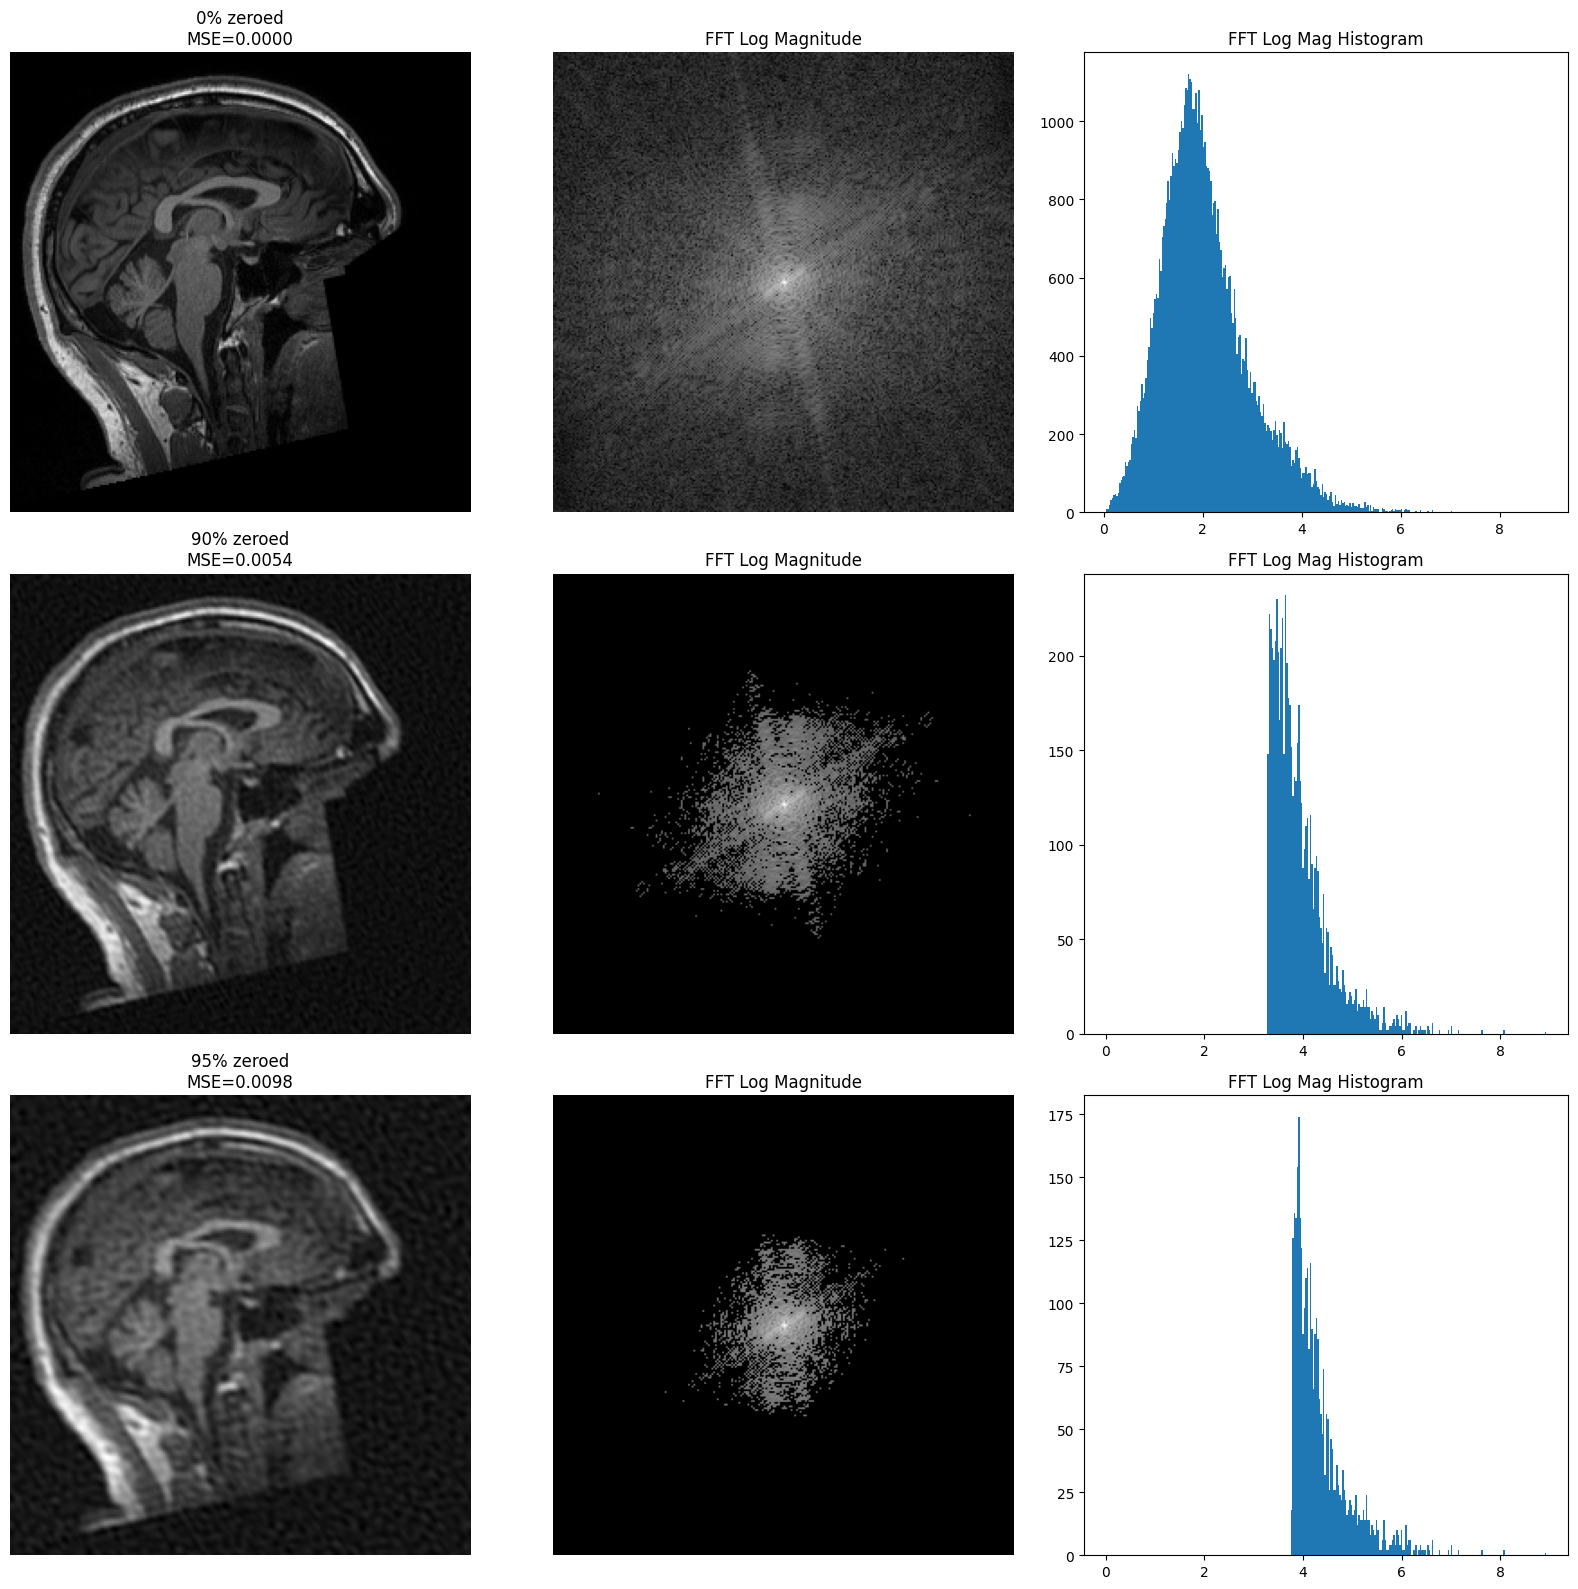

In [17]:
def compress_fft(img, s, cmap='gray', norm_factory=Normalize, hist_bins=300, axes=None, axes_row=0):
    FFT_img = np.fft.fftshift(np.fft.fft2(img))
    
    F_compressed = compress_array(FFT_img, s, interpolate=True)
    
    reconstructed = np.real(np.fft.ifft2(np.fft.ifftshift(F_compressed)))
    
    F_mag = np.abs(F_compressed)
    F_log_mag = np.log1p(F_mag)
    
    mse = get_mse(normalize_01(reconstructed), normalize_01(img))
    
    if axes is not None:
        plot_row(
            axes, axes_row,
            reconstructed, f"{s}% zeroed\nMSE={mse:.4f}",
            F_log_mag, "FFT Log Magnitude",
            F_log_mag, hist_bins, "FFT Log Mag Histogram", hist_zero_bin=False,
            cmap=cmap, norm_factory=norm_factory
        )
    return reconstructed, mse

# Set your compression levels
s_vals = [0, 90, 95]

fig, axes = plt.subplots(len(s_vals), 3, figsize=(16, 16))
for i, s in enumerate(s_vals):
    reconstructed, mse = compress_fft(guide, s, cmap='gray', norm_factory=Normalize, hist_bins=300, axes=axes, axes_row=i)
fig.tight_layout()
fig.savefig("figures/fft-compression.svg", transparent=True, bbox_inches='tight')

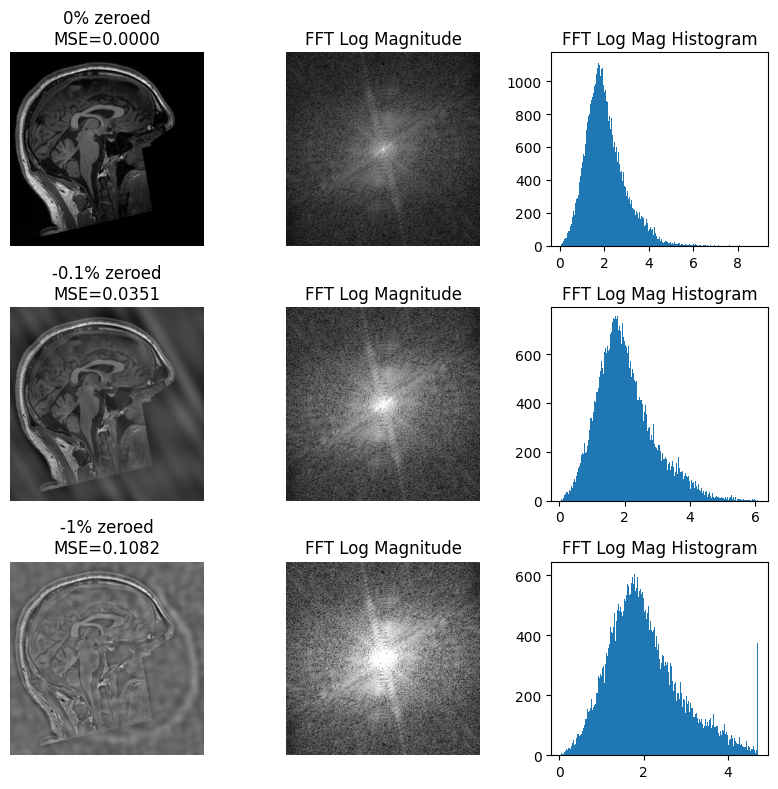

In [18]:
# Set your compression levels
s_vals = [0, -.1, -1]

fig, axes = plt.subplots(len(s_vals), 3, figsize=(8, 8))
for i, s in enumerate(s_vals):
    reconstructed, mse = compress_fft(guide, s, axes=axes, axes_row=i)
fig.tight_layout()

## Cameraman

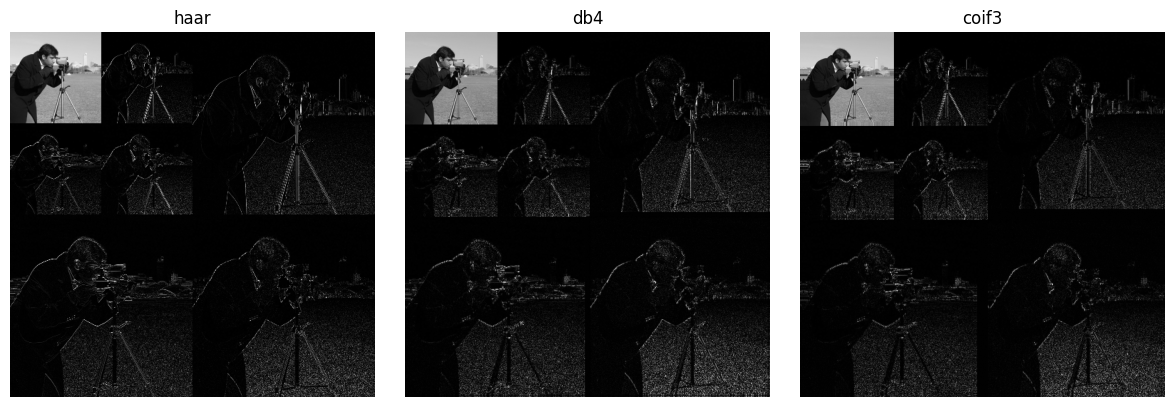

In [19]:
cameraman = pywt.data.camera()

wavelets = ['haar', 'db4', 'coif3']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for ax, wavelet in zip(axes, wavelets):
    coeffs = plot_wavelet(cameraman, wavelet=wavelet, level=2, cmap='abs_gray', norm_factory=CenteredNorm, ax=ax, normalize_indep=True, normalize_function=normalize_centered, verbose=False)
    ax.set_title(wavelet)
fig.tight_layout()
fig.savefig("figures/cameraman-wavelets.svg", transparent=True, bbox_inches='tight')

## Standard Basis Element

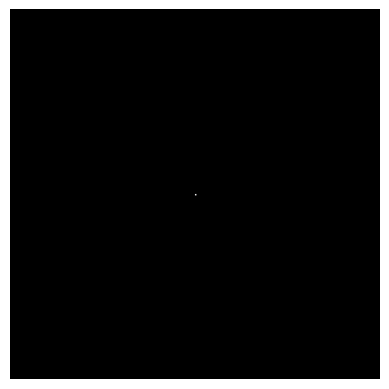

In [20]:
size = 256
imp_pos = (size // 2, size // 2)

# Create standard basis image (delta function)
imp_img = np.zeros((size, size))
imp_img[imp_pos] = 1.0

plt.imshow(imp_img, cmap='gray')
plt.axis('off')
plt.show()

In [21]:
def fft_row(img, title, cmap='gray', norm_factory=Normalize, hist_bins=300, axes=None, axes_row=0):
    FFT_img = np.fft.fftshift(np.fft.fft2(img))
    
    F_mag = np.abs(FFT_img)
    F_log_mag = np.log1p(F_mag)
    
    if axes is not None:
        plot_row(
            axes, axes_row,
            img, title,
            F_log_mag, "FFT Log Magnitude",
            F_log_mag, hist_bins, "FFT Log Mag Histogram", hist_zero_bin=False,
            cmap=cmap, norm_factory=norm_factory
        )

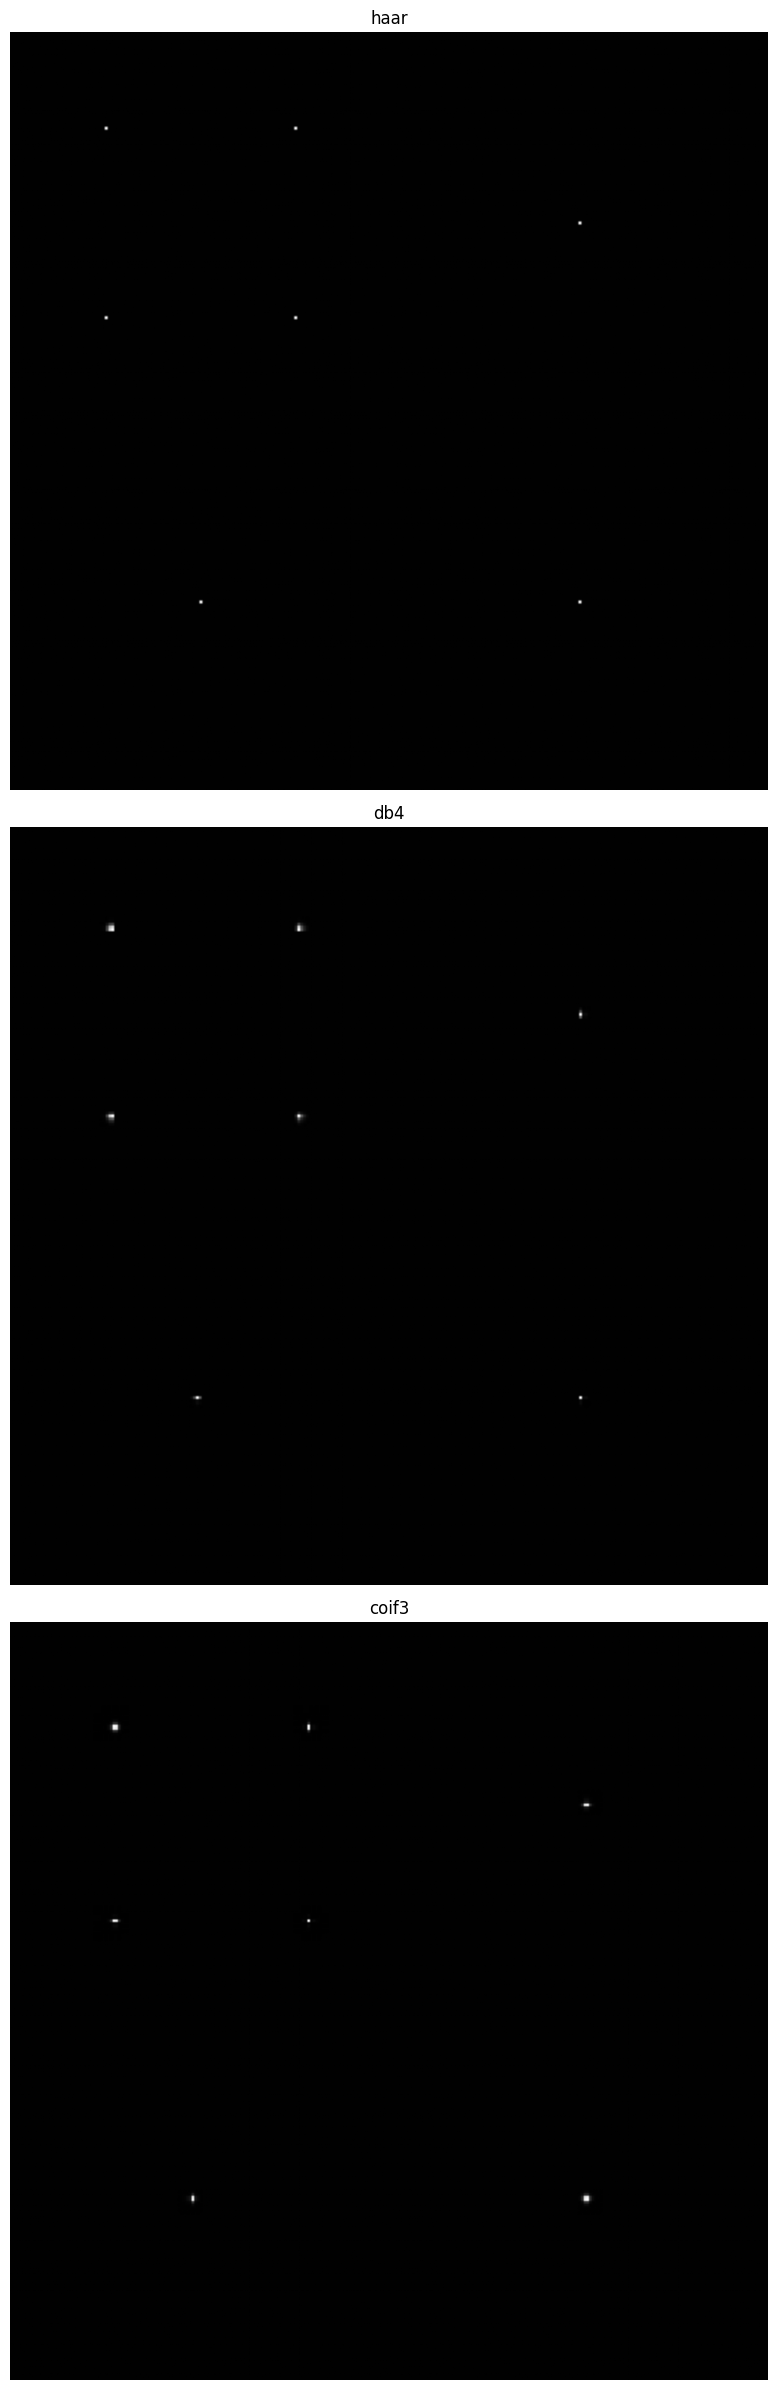

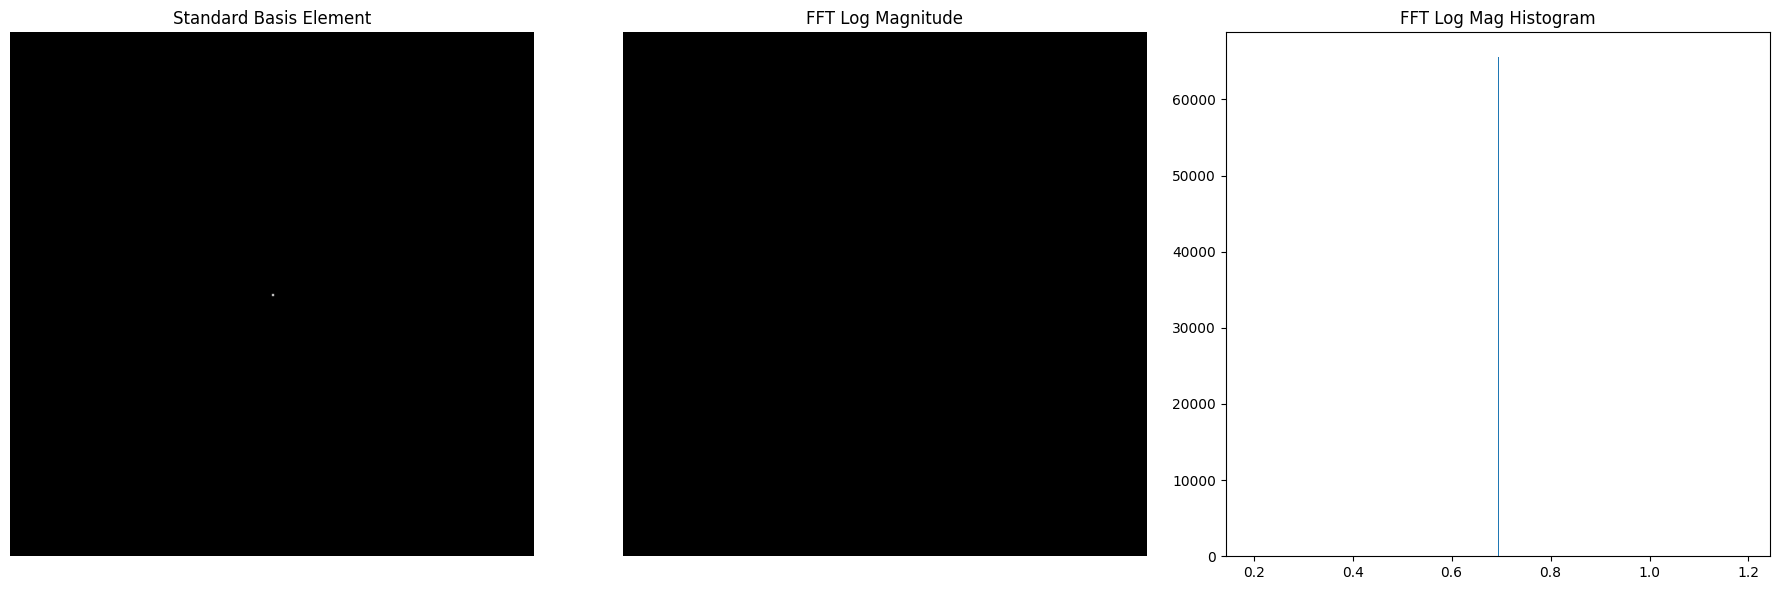

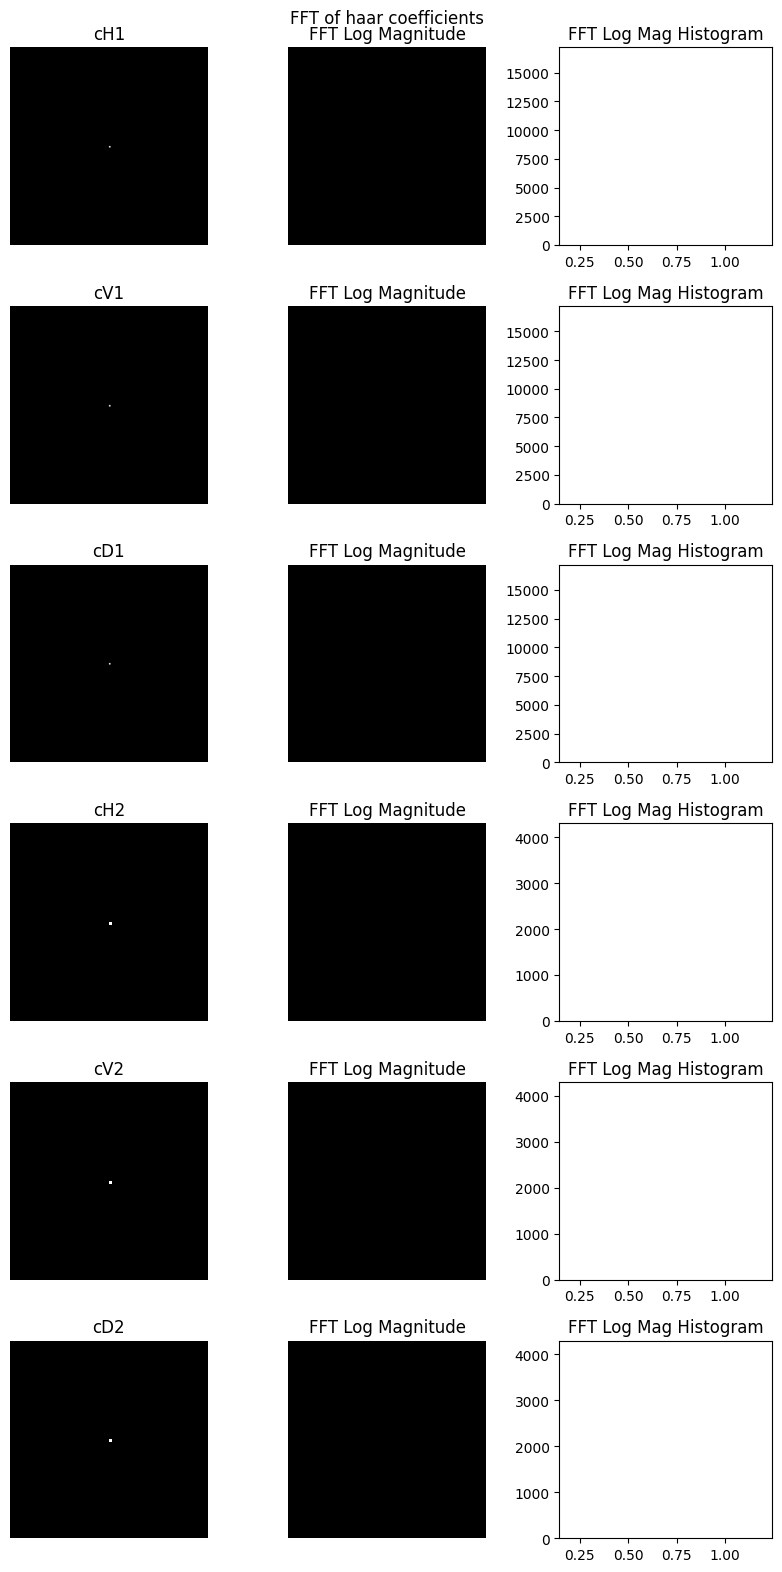

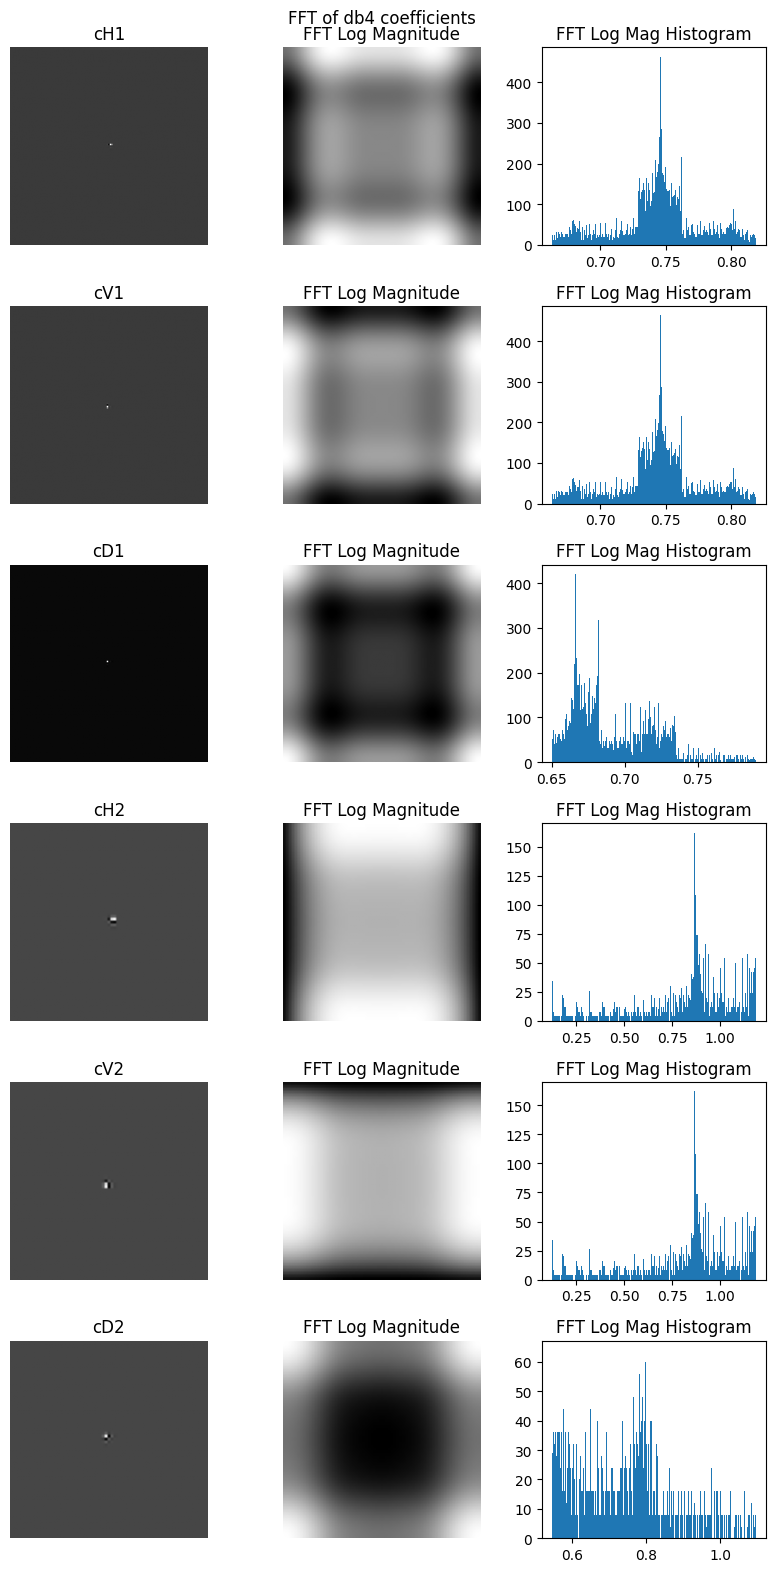

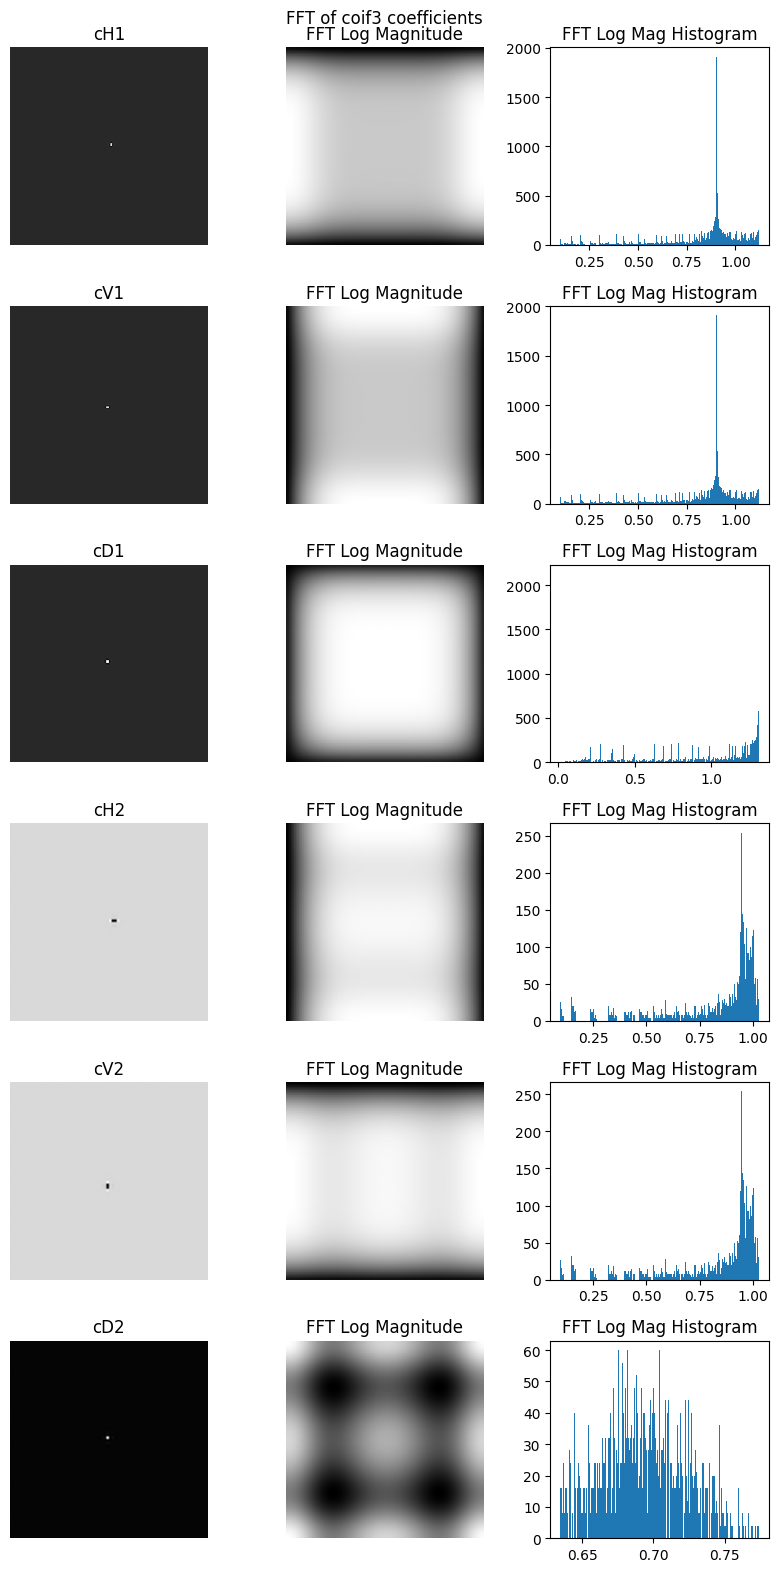

In [22]:
wavelets = ['haar', 'db4', 'coif3']
fig1, axes1 = plt.subplots(3, 1, figsize=(8, 24))
fig2, axes2 = plt.subplots(1, 3, figsize=(18, 6))
fft_row(imp_img, title='Standard Basis Element', cmap='gray', norm_factory=Normalize, hist_bins=300, axes=axes2, axes_row=0)
for i, (ax1, wavelet) in enumerate(zip(axes1, wavelets)):
    cAn, (cH2, cV2, cD2), (cH1, cV1, cD1) = plot_wavelet(imp_img, wavelet=wavelet, level=2, cmap='abs_gray', norm_factory=CenteredNorm, ax=ax1, normalize_indep=True)
    ax1.set_title(wavelet)
    fig3, axes3 = plt.subplots(6, 3, figsize=(8, 16))
    fft_row(cH1, title='cH1', cmap='gray', norm_factory=Normalize, hist_bins=300, axes=axes3, axes_row=0)
    fft_row(cV1, title='cV1', cmap='gray', norm_factory=Normalize, hist_bins=300, axes=axes3, axes_row=1)
    fft_row(cD1, title='cD1', cmap='gray', norm_factory=Normalize, hist_bins=300, axes=axes3, axes_row=2)
    fft_row(cH2, title='cH2', cmap='gray', norm_factory=Normalize, hist_bins=300, axes=axes3, axes_row=3)
    fft_row(cV2, title='cV2', cmap='gray', norm_factory=Normalize, hist_bins=300, axes=axes3, axes_row=4)
    fft_row(cD2, title='cD2', cmap='gray', norm_factory=Normalize, hist_bins=300, axes=axes3, axes_row=5)
    fig3.suptitle(f"FFT of {wavelet} coefficients")
    fig3.tight_layout()
    fig3.savefig(f"figures/fft-coeff-{wavelet}.svg", transparent=True, bbox_inches='tight')
fig1.tight_layout()
fig1.savefig("figures/standard-basis-element-wavelets.svg", transparent=True, bbox_inches='tight')
fig2.tight_layout()

## Canonical Spatial Representations

In [23]:
# wavelet_names = ['haar', 'db4', 'coif3']

# fig, axes = plt.subplots(2, len(wavelet_names), figsize=(12, 4))
# for i, name in enumerate(wavelet_names):
#     wavelet = pywt.Wavelet(name)
#     phi, psi, x = wavelet.wavefun(level=10)
#     axes[0, i].plot(x, phi)
#     axes[0, i].set_title(f'{name} - Scaling Function ($\\phi$)')
#     axes[0, i].grid(True)

#     axes[1, i].plot(x, psi)
#     axes[1, i].set_title(f'{name} - Wavelet Function ($\\psi$)')
#     axes[1, i].grid(True)

# fig.tight_layout()
# fig.savefig("figures/wavelet-functions.svg", transparent=True, bbox_inches='tight')

In [24]:
# wavelet_names = ['haar', 'db4', 'coif3']

# fig1, axes1 = plt.subplots(1, len(wavelet_names), figsize=(15, 5), subplot_kw={'projection': '3d'})
# fig2, axes2 = plt.subplots(1, len(wavelet_names), figsize=(15, 5))
# for i, name in enumerate(wavelet_names):
#     wavelet = pywt.Wavelet(name)
#     phi, psi, x = wavelet.wavefun(level=10)
    
#     X, Y = np.meshgrid(x, x)
#     Z = np.outer(phi, phi)

#     # 3D
#     axes1[i].plot_surface(X, Y, Z, cmap='viridis')
#     axes1[i].set_title(f'{name}')
#     axes1[i].axis('off')
    
#     # 2D weights
#     axes2[i].imshow(Z, extent=[x[0], x[-1], x[0], x[-1]], origin='lower')
#     axes2[i].set_title(f'{name} - 2D Weights ($\\phi \\otimes \\phi$)')
#     axes2[i].set_xlabel('x')
#     axes2[i].set_ylabel('y')
#     fig2.colorbar(axes2[i].imshow(Z, extent=[x[0], x[-1], x[0], x[-1]], origin='lower'), ax=axes2[i], orientation='vertical', pad=0.01)
#     axes2[i].axis('off')

# fig1.tight_layout()
# fig2.tight_layout()
# fig1.savefig("figures/wavelet-3d.svg", transparent=True, bbox_inches='tight')
# fig2.savefig("figures/wavelet-2d.svg", transparent=True, bbox_inches='tight')

## Wavelet Decomposition of Guide

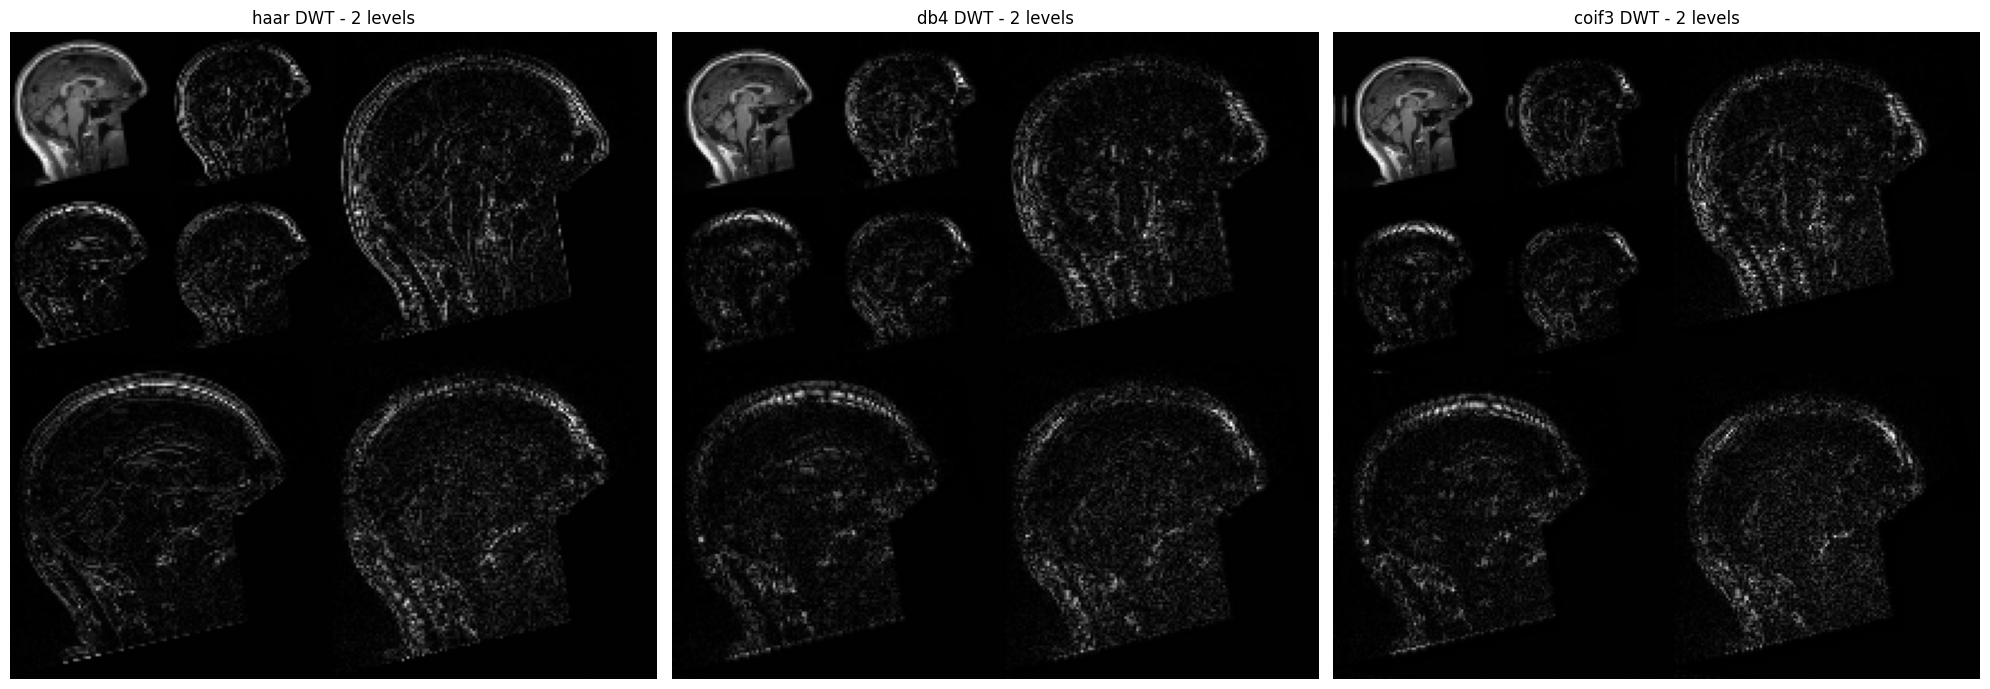

In [25]:
wavelets = ['haar', 'db4', 'coif3']
level = 2
fig, axes = plt.subplots(1, 3, figsize=(20, 8))
for ax, wavelet in zip(axes, wavelets):
    coeffs_arr = plot_wavelet(guide, wavelet=wavelet, level=level, cmap='abs_gray', norm_factory=CenteredNorm, ax=ax, normalize_indep=True, normalize_function=normalize_centered, verbose=False)
    ax.set_title(f"{wavelet} DWT - {level} level{'s' if len(coeffs_arr)-1 > 1 else ''}")
    # fig.colorbar(ax.images[0], ax=ax, orientation='vertical', pad=0.01)
fig.tight_layout()
fig.savefig("figures/guide-wavelets.svg", transparent=True, bbox_inches='tight')

In [26]:
def plot_histograms(axes, row, 
             transform_img, transform_title,
             hist_array, hist_bins, hist_title, hist_zero_bin=True,
             cmap='gray', norm_factory=Normalize,):
    # Column 1: transform
    ax1 = get_ax(axes, row, 0)
    ax1.imshow(transform_img, cmap=cmap, norm=norm_factory())
    ax1.set_title(transform_title)
    ax1.axis('off')

    # Column 2: histogram
    hist, bin_edges = np.histogram(hist_array.ravel(), bins=hist_bins)
    # Compute bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    # Set the count of the bin containing zero to zero
    if not hist_zero_bin:
        # Find the index of the bin that includes zero
        zero_bin_index = np.searchsorted(bin_edges, 0, side='right') - 1
        if 0 >= bin_edges[0] and 0 <= bin_edges[-1]:
            hist[zero_bin_index] = 0
    # Plot
    ax2 = get_ax(axes, row, 1)
    ax2.bar(bin_centers, hist, width=np.diff(bin_edges), align='center')
    ax2.set_title(hist_title)


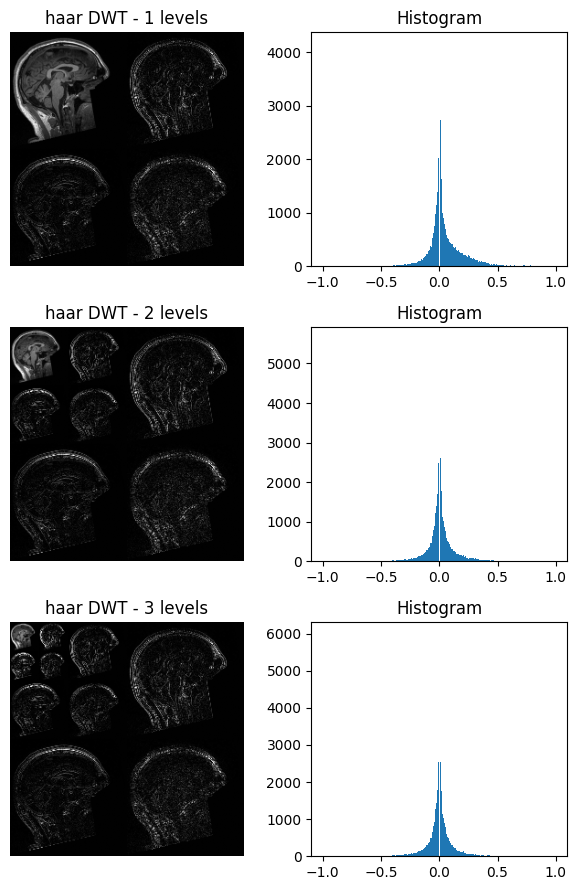

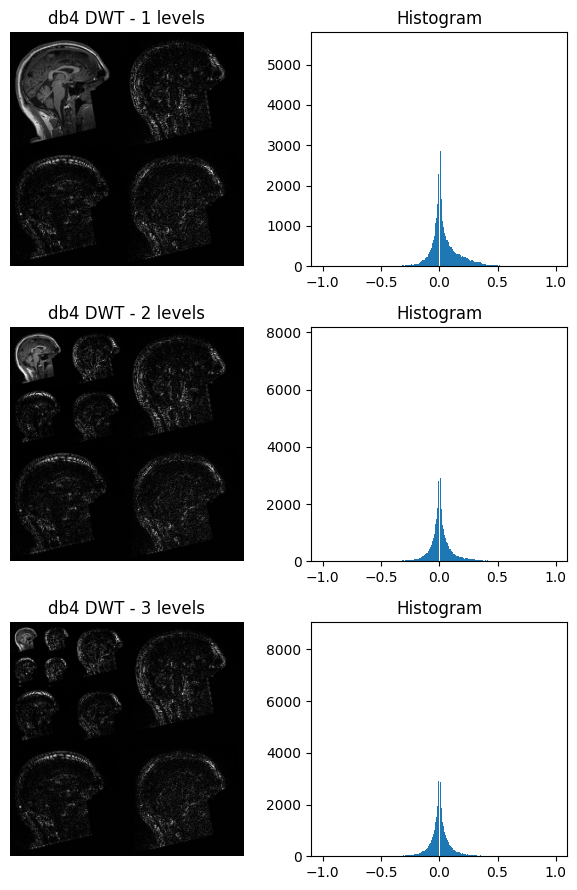

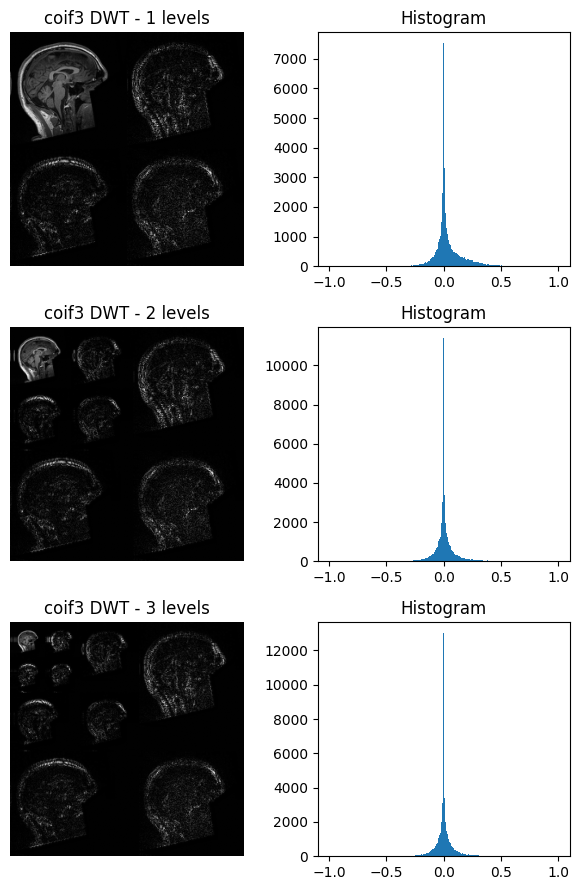

In [27]:
wavelets = ['haar', 'db4', 'coif3']
levels = [1, 2, 3]
for ax, wavelet in zip(axes, wavelets):
    fig, axes = plt.subplots(3, 2, figsize=(6, 9))
    for i, level in enumerate(levels):
        coeffs_arr, slices = plot_wavelet(guide, wavelet=wavelet, level=level, normalize_indep=True, verbose=False, return_arr=True)
        plot_histograms(
            axes, i,
            coeffs_arr, f"{wavelet} DWT - {level} level{'s' if len(coeffs_arr)-1 > 1 else ''}",
            coeffs_arr, 300, "Histogram", hist_zero_bin=False,
            cmap='abs_gray', norm_factory=CenteredNorm
        )
    fig.tight_layout()
    fig.savefig(f"figures/wavelet-histograms-{wavelet}.svg", transparent=True, bbox_inches='tight')

## Wavelet Compression

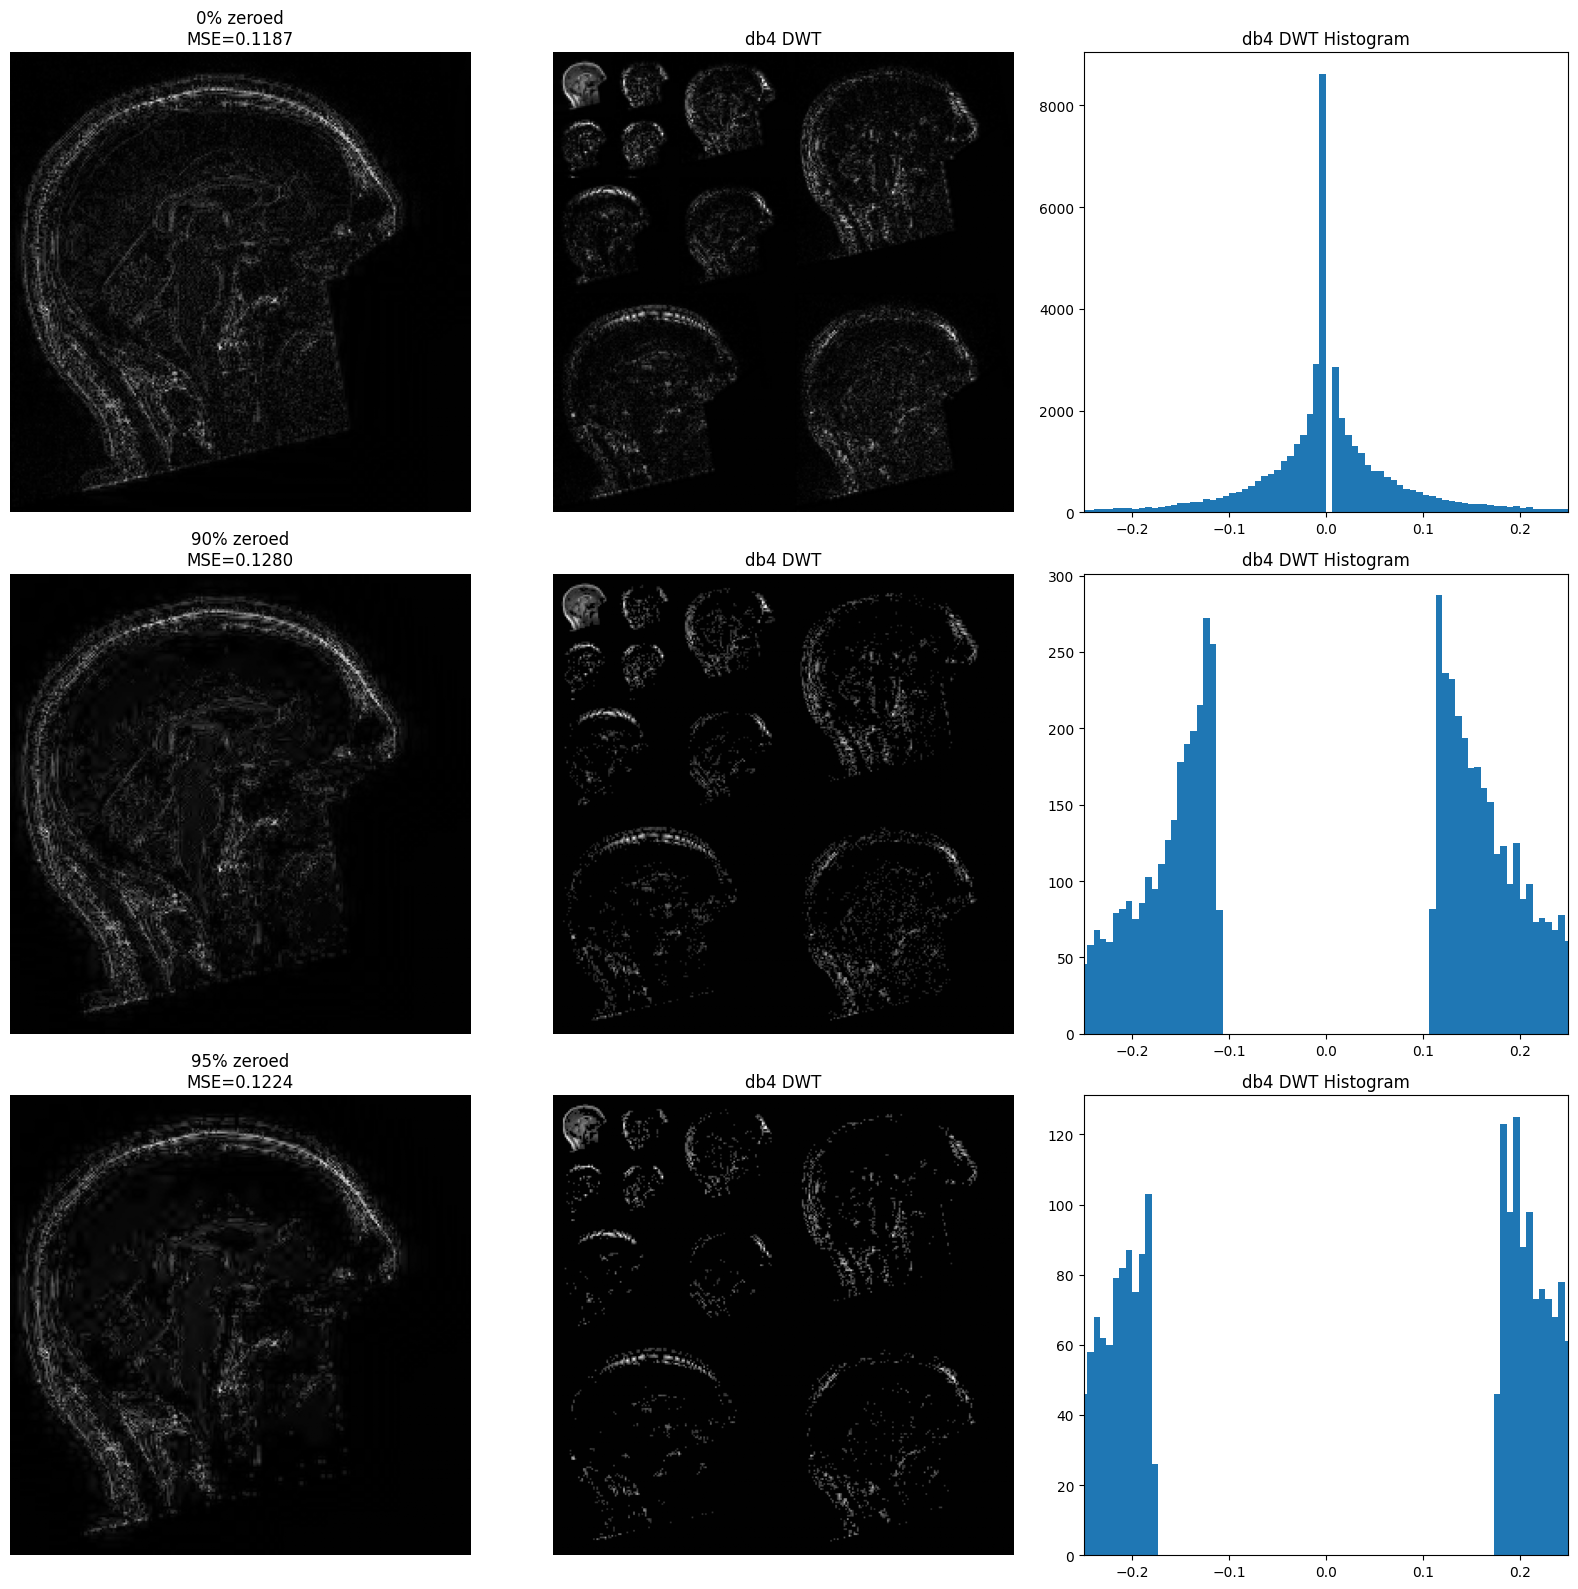

In [28]:
def compress_wav(img, s, wavelet='haar', level=2, cmap='gray', norm_factory=Normalize, normalize_indep=False, normalize_function=normalize_centered, hist_bins=300, axes=None, axes_row=0, verbose=False):
    coeffs = pywt.wavedec2(img, wavelet=wavelet, level=level)
    
    if normalize_indep:
        norm_coeffs = [normalize_function(coeffs[0])]
        for i, (cH, cV, cD) in enumerate(coeffs[1:], 1):
            norm_cH = normalize_function(cH)
            norm_cV = normalize_function(cV)
            norm_cD = normalize_function(cD)
            norm_coeffs.append((norm_cH, norm_cV, norm_cD))
        coeffs = norm_coeffs
        arr, slices = pywt.coeffs_to_array(norm_coeffs)
    else:
        arr, slices = pywt.coeffs_to_array(coeffs)
    arr_compressed = compress_array(arr, s)
    coeffs_compressed = pywt.array_to_coeffs(arr_compressed, slices, output_format='wavedec2')

    reconstructed = pywt.waverec2(coeffs_compressed, wavelet=wavelet)

    mse = get_mse(normalize_01(reconstructed), normalize_01(img))
    
    if verbose:
        # Level 0 Approximation coefficients
        print("Approximation coefficients (Level 0):")
        describe_array(coeffs[0], ['count', 'min', 'max', '25%', '50%', '75%'])
        
        # Level n Detail coefficients
        for level in range(1, len(coeffs)):
            print(f"Detail coefficients (Level {level}):")
            for label, coeff in zip(['Horizontal (cH)', 'Vertical (cV)', 'Diagonal (cD)'], coeffs[level]):
                print(f"  {label}:")
                desc = describe_array(coeff, stats=['count', 'min', 'max', '25%', '50%', '75%'])

    if axes is not None:
        plot_row(
            axes, axes_row,
            reconstructed, f"{s}% zeroed\nMSE={mse:.4f}",
            arr_compressed, f"{wavelet} DWT",
            arr_compressed, hist_bins, f"{wavelet} DWT Histogram", hist_zero_bin=False,
            cmap=cmap, norm_factory=norm_factory
        )
    return reconstructed, mse

s_vals = [0, 90, 95]

fig, axes = plt.subplots(len(s_vals), 3, figsize=(16, 16))
for i, s in enumerate(s_vals):
    reconstructed, mse = compress_wav(guide, s, wavelet='db4', level=3, cmap='abs_gray', norm_factory=CenteredNorm, normalize_indep=True, hist_bins=300, axes=axes, axes_row=i, verbose=False)
    axes[i, 2].set_xlim(-.25, .25)
    # fig.colorbar(axes[i, 1].images[0], ax=axes[i, 1], orientation='vertical', pad=0.01)
fig.tight_layout()
fig.savefig("figures/wavelet-compression.svg", transparent=True, bbox_inches='tight')

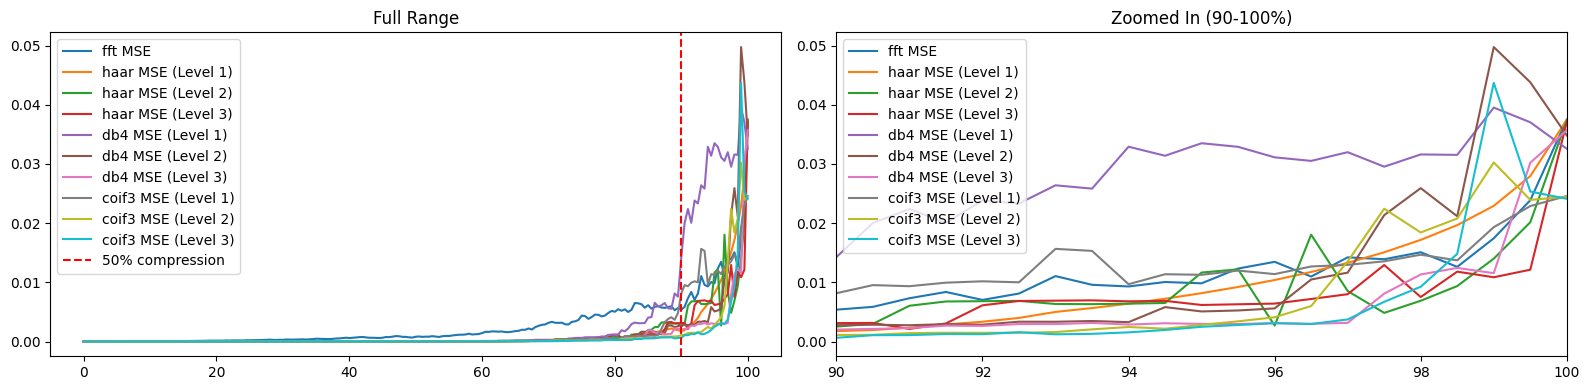

In [30]:
s_vals = np.linspace(0, 100, 201)

domain_options = [
    ('fft', ('fft', None)),
    ('haar level 1', ('haar', 1)),
    ('haar level 2', ('haar', 2)),
    ('haar level 3', ('haar', 3)),
    ('db4 level 1', ('db4', 1)),
    ('db4 level 2', ('db4', 2)),
    ('db4 level 3', ('db4', 3)),
    ('coif3 level 1', ('coif3', 1)),
    ('coif3 level 2', ('coif3', 2)),
    ('coif3 level 3', ('coif3', 3))
]
domains = [opt[1] for opt in domain_options]

mse_vals = {}
reconstructed_frames = {}

for wavelet, level in domains:
    mse_vals[(wavelet, level)] = []
    reconstructed_frames[(wavelet, level)] = []
    for s in s_vals:
        if wavelet == 'fft':
            reconstructed, mse = compress_fft(guide, s)
        else:
            reconstructed, mse = compress_wav(guide, s, wavelet=wavelet, level=level)
        reconstructed_frames[(wavelet, level)].append(reconstructed)
        mse_vals[(wavelet, level)].append(mse)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

for (wavelet, level), mse in mse_vals.items():
    label = f'{wavelet} MSE' if level is None else f'{wavelet} MSE (Level {level})'
    axes[0].plot(s_vals, mse, label=label)
axes[0].axvline(90, color='red', linestyle='--', label='50% compression')
axes[0].legend()
axes[0].set_title("Full Range")

for (wavelet, level), mse in mse_vals.items():
    label = f'{wavelet} MSE' if level is None else f'{wavelet} MSE (Level {level})'
    axes[1].plot(s_vals, mse, label=label)
axes[1].set_xlim(90, 100)
axes[1].legend()
axes[1].set_title("Zoomed In (90-100%)")

fig.tight_layout()
fig.savefig("figures/mse-compression.svg", transparent=True, bbox_inches='tight')


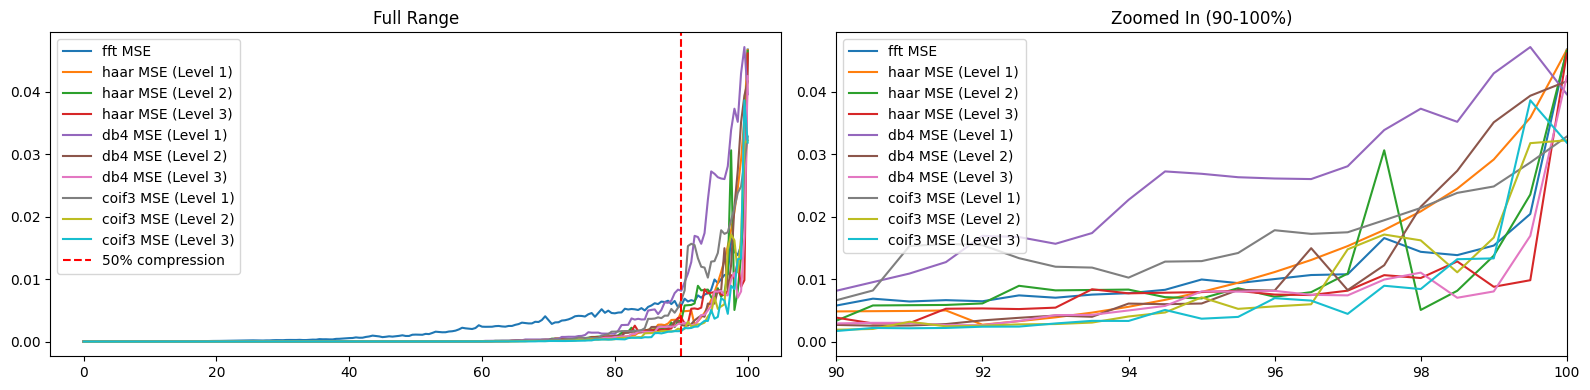

In [31]:
s_vals = np.linspace(0, 100, 201)

domain_options = [
    ('fft', ('fft', None)),
    ('haar level 1', ('haar', 1)),
    ('haar level 2', ('haar', 2)),
    ('haar level 3', ('haar', 3)),
    ('db4 level 1', ('db4', 1)),
    ('db4 level 2', ('db4', 2)),
    ('db4 level 3', ('db4', 3)),
    ('coif3 level 1', ('coif3', 1)),
    ('coif3 level 2', ('coif3', 2)),
    ('coif3 level 3', ('coif3', 3))
]
domains = [opt[1] for opt in domain_options]

mse_vals = {}
reconstructed_frames = {}

for wavelet, level in domains:
    mse_vals[(wavelet, level)] = []
    reconstructed_frames[(wavelet, level)] = []
    for s in s_vals:
        if wavelet == 'fft':
            reconstructed, mse = compress_fft(guide_T2, s)
        else:
            reconstructed, mse = compress_wav(guide_T2, s, wavelet=wavelet, level=level)
        reconstructed_frames[(wavelet, level)].append(reconstructed)
        mse_vals[(wavelet, level)].append(mse)

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

for (wavelet, level), mse in mse_vals.items():
    label = f'{wavelet} MSE' if level is None else f'{wavelet} MSE (Level {level})'
    axes[0].plot(s_vals, mse, label=label)
axes[0].axvline(90, color='red', linestyle='--', label='50% compression')
axes[0].legend()
axes[0].set_title("Full Range")

for (wavelet, level), mse in mse_vals.items():
    label = f'{wavelet} MSE' if level is None else f'{wavelet} MSE (Level {level})'
    axes[1].plot(s_vals, mse, label=label)
axes[1].set_xlim(90, 100)
axes[1].legend()
axes[1].set_title("Zoomed In (90-100%)")

fig.tight_layout()
fig.savefig("figures/mse-compression_T2.svg", transparent=True, bbox_inches='tight')


## Comparison Widget

In [32]:
slider = widgets.FloatSlider(
    value=95,
    min=0,
    max=100,
    step=100/(len(s_vals)-1),
    description='Compression:',
    continuous_update=True,
    layout=widgets.Layout(width='100%'),
)
xlim_slider = widgets.FloatRangeSlider(
    value=(90, 100),
    min=min(s_vals),
    max=max(s_vals),
    step=(max(s_vals)-min(s_vals)) / (len(s_vals)-1),
    description='X Lim:',
    continuous_update=True,
    layout=widgets.Layout(width='100%'),
)
domains_dropdown = widgets.SelectMultiple(
    options=domain_options,
    value=[('fft', None), ('haar', 2)],
    description='Domains:',
    layout=widgets.Layout(height='200px'),
)
cmap_dropdown = widgets.Dropdown(
    options=['gray', 'seismic'],
    value='gray',
    description='cmap:',
)
norm_dropdown = widgets.Dropdown(
    options=[('CenteredNorm', CenteredNorm), ('Linear', Normalize)],
    value=Normalize,
    description='norm:',
)

dropdown_controls = HBox([
    domains_dropdown,
    cmap_dropdown,
    norm_dropdown
])

frame_out = Output()
mse_out   = Output()

def update(s, xlim_range, domains, cmap, norm_factory):
    frame_index = int((s * (len(s_vals)-1)) // 100)

    with frame_out:
        frame_out.clear_output(wait=True)
        
        num_domains = len(domains)
        cols = min(3, num_domains)
        rows = int(np.ceil(num_domains/cols))
        fig1, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows))
        axes = np.array(axes).flatten()
        for i, domain in enumerate(domains):
            img = reconstructed_frames[domain][frame_index]
            axes[i].imshow(img, cmap=cmap, norm=norm_factory())
            axes[i].set_title(f'{domain} Frame {frame_index}\n{s}% zeroed')
            axes[i].axis('off')
            
        for ax in axes[num_domains:]:
            ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    with mse_out:
        mse_out.clear_output(wait=True)
        fig2, ax2 = plt.subplots(1, 1, figsize=(10, 4))
        for (wavelet, level), mse in mse_vals.items():
            lbl = f'{wavelet} MSE' if level is None else f'{wavelet} MSE (Level {level})'
            is_selected = (wavelet, level) in domains
            lw = 3 if is_selected else 1
            alpha = 1.0 if is_selected else 0.3
            ax2.plot(s_vals, mse, label=lbl, linewidth=lw, alpha=alpha)
        ax2.set_xlim(xlim_range)
        ax2.axvline(s, linestyle='--', linewidth=1, label=f'Current s={s}%')
        ax2.legend()
        ax2.set_title('Reconstruction MSE vs Compression')
        ax2.set_xlabel('Percent Zeroed (%)')
        ax2.set_ylabel('MSE')
        plt.tight_layout()
        plt.show()

out = interactive_output(update, {
    's': slider,
    'xlim_range': xlim_slider,
    'domains': domains_dropdown,
    'cmap': cmap_dropdown,
    'norm_factory': norm_dropdown,
})

display(HBox([
    frame_out,
    VBox([
        mse_out,
        slider,
        xlim_slider,
        dropdown_controls
    ], layout=widgets.Layout(align_items='stretch'))
]), out)


Output()

## Gradient Descent

np.float64(1e-07)

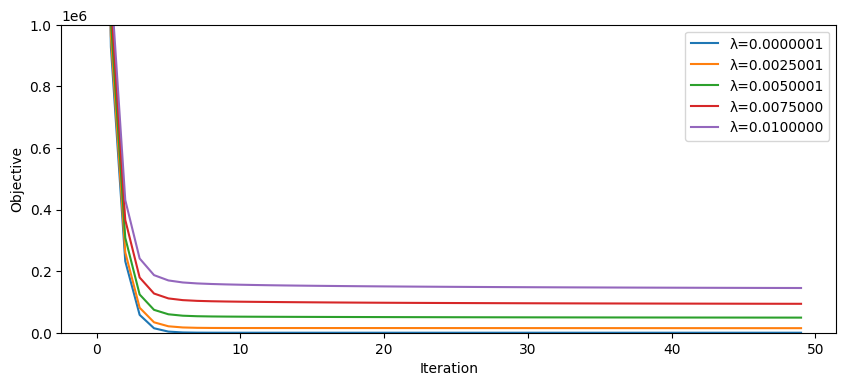

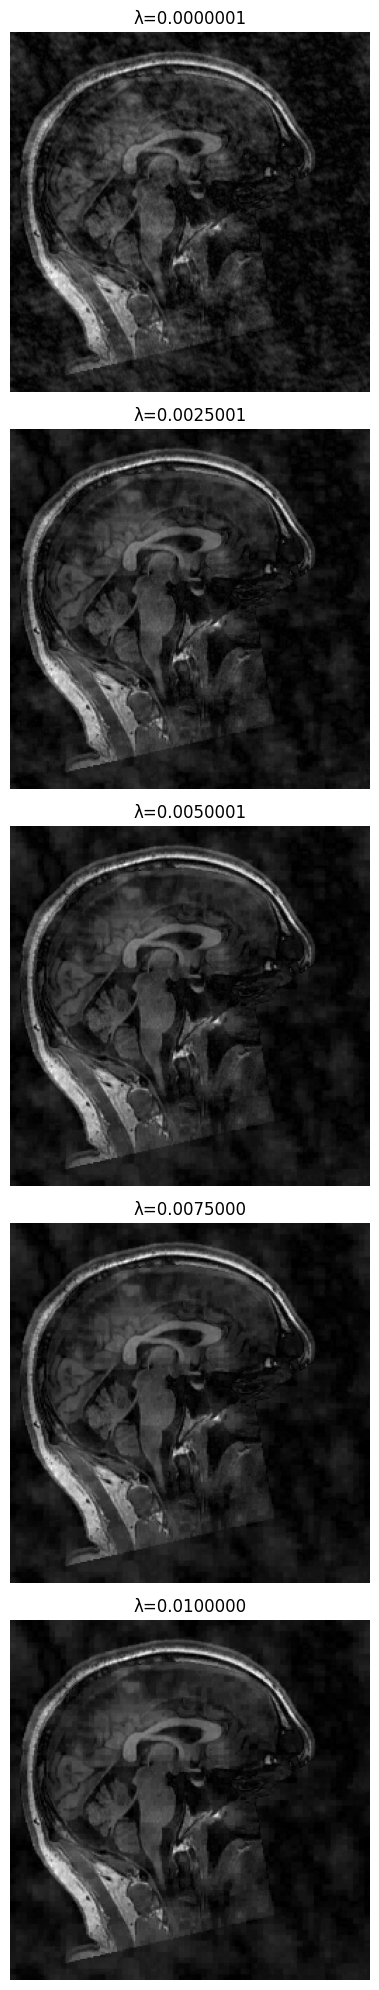

In [64]:
def soft_thresh(x, tau):
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0.)

def wavelet_thresh(x, tau):
    coeffs = pywt.wavedec2(x, wavelet, level=level)
    thresh_coeffs = [coeffs[0]] + [
        tuple(soft_thresh(detail, tau) for detail in coeffs[i])
        for i in range(1, len(coeffs))
    ]
    return pywt.waverec2(thresh_coeffs, wavelet)

def proximal_gradient_reconstruct(y, mask, lam, x0, n_iters, alpha):
    x = x0.copy()
    f_vals = []
    for i in range(n_iters):
        grad = np.fft.ifft2(mask * (np.fft.fft2(x) - y))

        x = x - alpha * grad
        x = wavelet_thresh(np.real(x), alpha * lam)

        data_fid = 0.5 * np.linalg.norm(mask * np.fft.fft2(x) - y)**2
        coeffs = pywt.wavedec2(x, wavelet, level=level)
        sparsity = sum(np.sum(np.abs(c)) for c in coeffs[1:])
        f_vals.append(data_fid + lam * sparsity)
    return x, np.array(f_vals)

img = guide
ground_truth = np.fft.fft2(img)

img_shape = np.shape(ground_truth)
p = 0.5
wavelet = 'haar'
level = 2
alpha = 1.0 # step size
n_iters = 50 # number of iterations
lambda_candidates = np.linspace(0.0000001, 0.01, 5)

mask = (np.random.rand(*img_shape) < p).astype(float)
y = mask * ground_truth
x0 = np.fft.ifft2(y)

f_lambda = {}
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 4))
fig2, axes2 = plt.subplots(len(lambda_candidates), 1, figsize=(8, 4*len(lambda_candidates)))
for i, lam in enumerate(lambda_candidates):
    x, f_vals = proximal_gradient_reconstruct(y, mask, lam, x0, n_iters, alpha)
    f_lambda[lam] = f_vals
    axes2[i].imshow(np.abs(x), cmap='gray', norm=Normalize())
    axes2[i].set_title(f'λ={lam:.7f}')
    axes2[i].axis('off')
    ax1.plot(f_vals, label=f'λ={lam:.7f}')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Objective')
ax1.set_ylim(0, 1000000)
ax1.legend()
fig1.savefig("figures/lambdas.svg", transparent=True, bbox_inches='tight')

fig2.tight_layout()
fig2.savefig("figures/lambdas-frames.svg", transparent=True, bbox_inches='tight')

best_lambda = min(lambda_candidates, key=lambda lam: f_lambda[lam][-1])
best_lambda


Processing p=0.75: 100%|██████████| 1000/1000 [04:43<00:00,  3.52it/s]


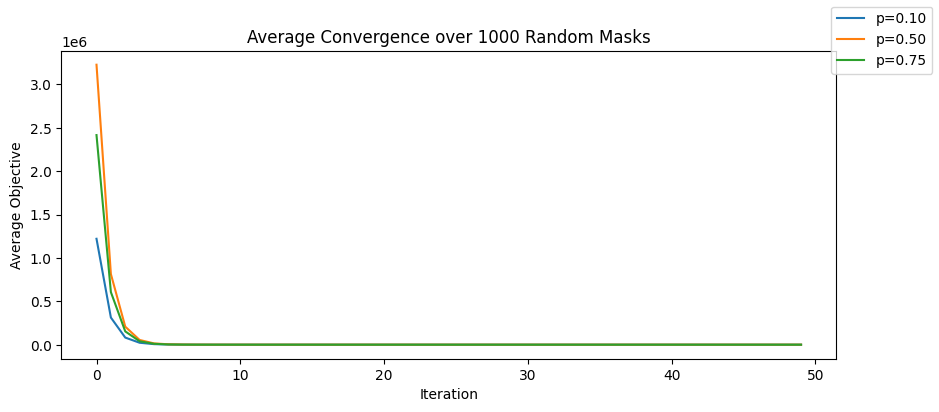

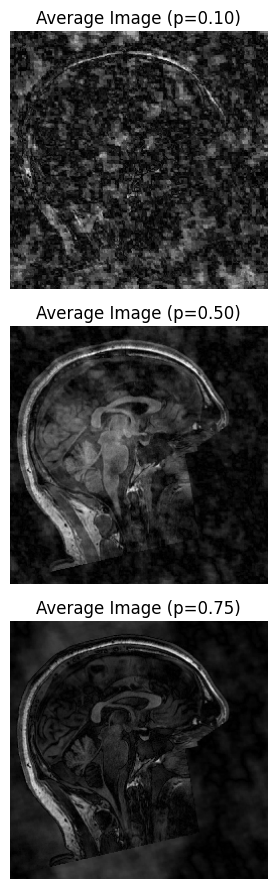

In [34]:
p_values = [0.1, 0.5, .75]
n_runs = 1000
all_f = np.zeros((n_runs, n_iters))
fig1, ax1 = plt.subplots(1, 1, figsize=(10, 4))
fig2, axes2 = plt.subplots(3, 1, figsize=(6, 9))

for i, p in enumerate(p_values):
    for j in tqdm(range(n_runs), desc=f'Processing p={p:.2f}'):
        mask = (np.random.rand(*img_shape) < p).astype(float)
        y = mask * ground_truth
        x0 = np.fft.ifft2(y)
        x, f_vals = proximal_gradient_reconstruct(y, mask, best_lambda, x0, n_iters, alpha)
        all_f[j] = f_vals.real

    avg_f = all_f.mean(axis=0)
    ax1.plot(avg_f, label=f'p={p:.2f}')
    axes2[i].imshow(np.abs(x), cmap='gray', norm=Normalize())
    axes2[i].set_title(f'Average Image (p={p:.2f})')
    axes2[i].axis('off')

ax1.set_xlabel('Iteration')
ax1.set_ylabel('Average Objective')
ax1.set_title(f'Average Convergence over {n_runs} Random Masks')
fig1.legend()
fig1.savefig("figures/average-convergence.svg", transparent=True, bbox_inches='tight')

fig2.tight_layout()
fig2.savefig("figures/average-images.svg", transparent=True, bbox_inches='tight')
